In [161]:
import networkx as nx
import matplotlib.pyplot as plt
from synutility.SynIO.data_type import load
from synutility.SynVis.graph_visualizer import GraphVisualizer
from typing import Tuple
import time
from itertools import chain, combinations
import pandas as pd
import numpy as np
from numpy.linalg import matrix_rank

In [162]:
data = load('data/ITS_graphs.pkl.gz')
data = load('data/ITS_graphs.pkl.gz')

In [163]:
# WP 1: find reaction center

def get_reaction_center(its_graph, l_depth = 0):
    
    rc = set()
    for (u,v,d) in its_graph.edges(data=True):
        if d["standard_order"] != 0:
            rc = rc | {u, v}
    
    for l in range(l_depth):
        l_neighborhood = set()
        for n in rc:
            l_neighborhood = l_neighborhood | set(its_graph.neighbors(n))
        rc = rc | l_neighborhood
        
    return nx.induced_subgraph(its_graph, rc).copy()

In [164]:
# WP 1: calculate all reaction centers

for reaction in data:
    
    its_graph = reaction['ITS']
    reaction_center = get_reaction_center(its_graph, 1)
    reaction['RC'] = reaction_center

In [165]:
data[0]

{'R-id': 7873,
 'ITS': <networkx.classes.graph.Graph at 0x2d3ab176790>,
 'class': 0,
 'RC': <networkx.classes.graph.Graph at 0x2d484b57390>}

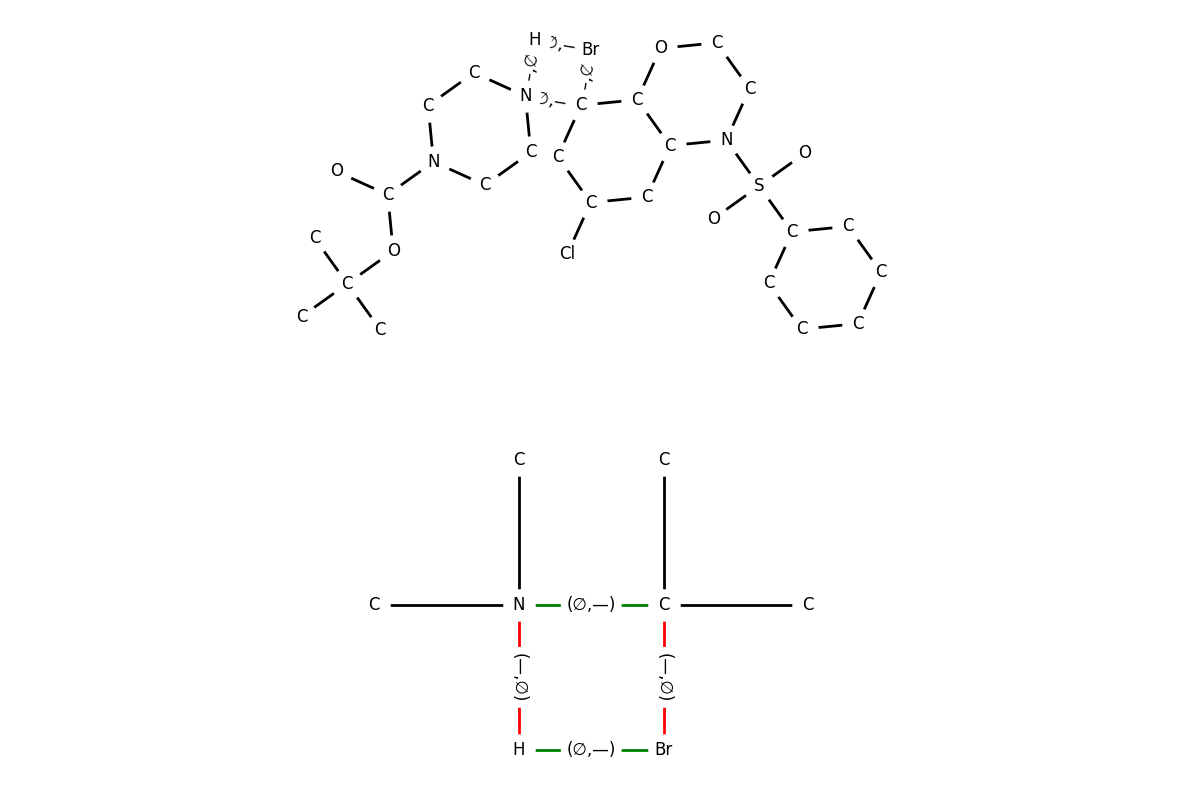

In [166]:
its_graph = data[0]['ITS']
reaction_center = data[0]['RC']

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
vis = GraphVisualizer()

# Plot ITS graph and its reaction center
vis.plot_its(its_graph, ax[0], use_edge_color=True)
vis.plot_its(reaction_center, ax[1], use_edge_color=True)

# Display the plots
plt.show()

In [ ]:
# WP 2:

def isomorphism_clustering(prefiltered_clusters: dict) -> Tuple[dict, int]:

    final_clusters = dict()
    isomorphism_check_count = 0
    
    for prefiltered_cluster in prefiltered_clusters.values():
        new_clusters = dict()
    
        for reaction in prefiltered_cluster:
            rc = reaction['RC']
            for rc_key in new_clusters.keys():
                isomorphism_check_count += 1
                if nx.is_isomorphic(
                    rc,
                    rc_key,
                    lambda n1, n2: n1['charge'] == n2['charge'] and n1['element'] == n2['element'],
                    lambda e1, e2: e1['order'] == e2['order']
                ):
                    new_clusters[rc_key].append(reaction)
                    break
            else:
                new_clusters[rc] = [reaction]
        
        final_clusters.update(new_clusters)
        
    return final_clusters, isomorphism_check_count

In [169]:
# clusters, _ = isomorphism_clustering({"trivial_cluster" : data})
# print(len(clusters))
# clusters

{<networkx.classes.graph.Graph at 0x2d484b57390>: [{'R-id': 7873,
   'ITS': <networkx.classes.graph.Graph at 0x2d3ab176790>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d484b57390>},
  {'R-id': 44597,
   'ITS': <networkx.classes.graph.Graph at 0x2d43bce0450>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d4ca9eaa10>},
  {'R-id': 29514,
   'ITS': <networkx.classes.graph.Graph at 0x2d43bf48590>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d4ca00d350>},
  {'R-id': 33834,
   'ITS': <networkx.classes.graph.Graph at 0x2d43cc0bc50>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d4c3e8ab90>},
  {'R-id': 13675,
   'ITS': <networkx.classes.graph.Graph at 0x2d43d963710>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d4be346350>},
  {'R-id': 47867,
   'ITS': <networkx.classes.graph.Graph at 0x2d43f17cd10>,
   'class': 0,
   'RC': <networkx.classes.graph.Graph at 0x2d4b35bff90>},
  {'R-id': 35139,
   'ITS': <networkx.classes.

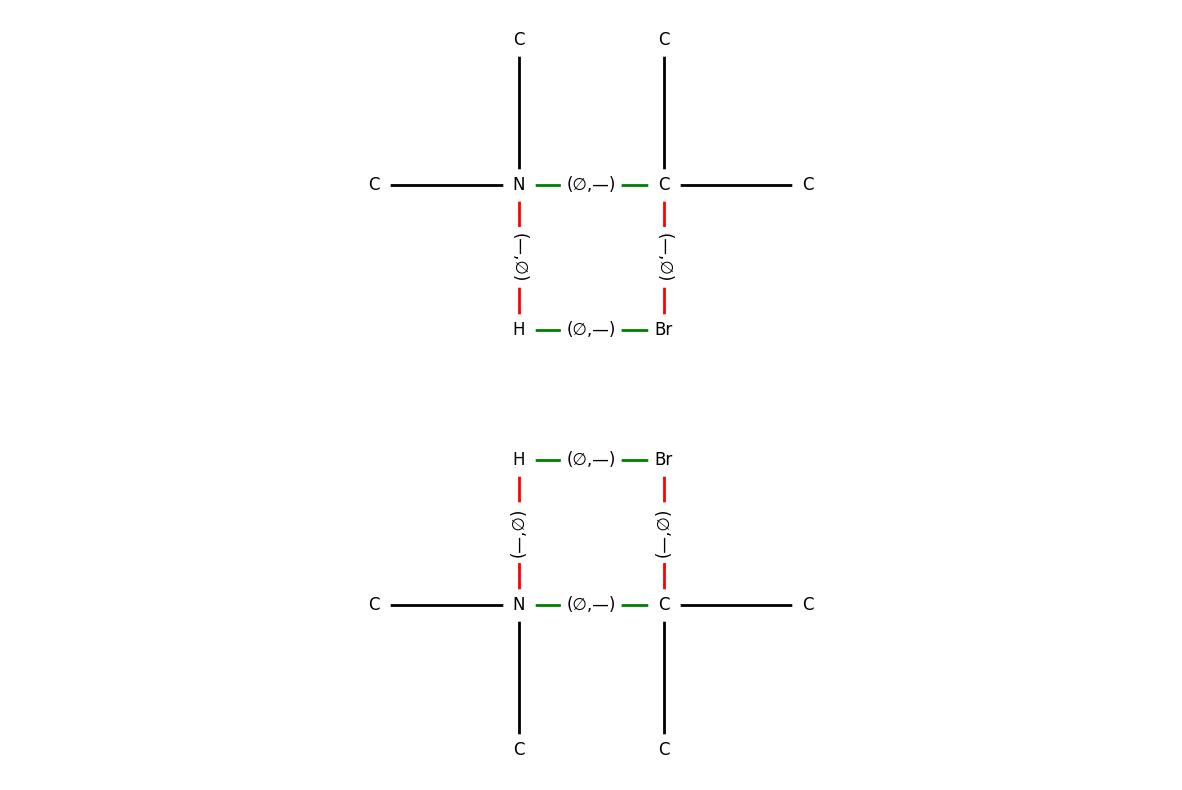

In [170]:
# first_cluster = next(iter(clusters.values()))
# 
# rc1 = first_cluster[0]['RC']
# rc2 = first_cluster[1]['RC']
# 
# fig, ax = plt.subplots(2, 1, figsize=(15, 10))
# vis = GraphVisualizer()
# 
# # Plot ITS graph and its reaction center
# vis.plot_its(rc1, ax[0], use_edge_color=True)
# vis.plot_its(rc2, ax[1], use_edge_color=True)
# 
# # Display the plots
# plt.show()

In [171]:
len(data)

34395

In [172]:
# WP 3:

def vertex_count(G: nx.Graph) -> int:
    return G.number_of_nodes()

def edge_count(G: nx.Graph) -> int:
    return G.number_of_edges()

def vertex_degrees(G: nx.Graph) -> Tuple[int]:
    degree_list = [v for _, v in G.degree()]
    degree_list.sort()
    return tuple(degree_list)

def algebraic_connectivity(G: nx.Graph) -> float:
    return nx.algebraic_connectivity(G, seed=1337)

def rank(G: nx.Graph) -> int:
    adjacency_matrix = nx.to_numpy_array(G)
    return int(matrix_rank(adjacency_matrix))

# WP 4 (Version A):

def weisfeiler_lehman_graph_hash(G: nx.Graph, iterations: int = 3) -> str:
    for node, data in G.nodes(data=True):
        charge = data.get('charge', '')
        element = data.get('element', '')
        G.nodes[node]['combined'] = f"{charge}{element}"
    
    return nx.weisfeiler_lehman_graph_hash(G, edge_attr='order', node_attr='combined', iterations=iterations)
    

def weisfeiler_lehman_graph_hash_no_attributes(G: nx.Graph, iterations: int = 3) -> str:
    
    return nx.weisfeiler_lehman_graph_hash(G, iterations=iterations)

invariant_functions = {
    "none": lambda G: "trivial_cluster",
    "vertex_count": vertex_count,
    "edge_count": edge_count,
    "vertex_degrees": vertex_degrees,
#    "algebraic_connectivity": algebraic_connectivity,
    "rank": rank,
    "weisfeiler_lehman_graph_hash_(1)": lambda G: weisfeiler_lehman_graph_hash(G, 1),
    "weisfeiler_lehman_graph_hash_(2)": lambda G: weisfeiler_lehman_graph_hash(G, 2),
    "weisfeiler_lehman_graph_hash_(3)": lambda G: weisfeiler_lehman_graph_hash(G, 3),
#    "weisfeiler_lehman_graph_hash_no_attributes_(1)": lambda G: weisfeiler_lehman_graph_hash_no_attributes(G, 1),
}

In [173]:
graph_invariants = dict()

for invariant_name, invariant_func in invariant_functions.items():

    start_time = time.time()

    graph_invariants[invariant_name] = {
        "reactions": {}
    }
    
    for reaction in data:

        r_id = reaction['R-id']

        graph_invariants[invariant_name]['reactions'][r_id] = invariant_func(reaction['RC'])


    end_time = time.time()

    graph_invariants[invariant_name]['execution_time_ms'] = (end_time - start_time) * 1000

In [174]:
graph_invariants

{'none': {'reactions': {7873: 'trivial_cluster',
   42468: 'trivial_cluster',
   24541: 'trivial_cluster',
   40699: 'trivial_cluster',
   34914: 'trivial_cluster',
   11951: 'trivial_cluster',
   15509: 'trivial_cluster',
   49367: 'trivial_cluster',
   28488: 'trivial_cluster',
   10715: 'trivial_cluster',
   7385: 'trivial_cluster',
   32017: 'trivial_cluster',
   24945: 'trivial_cluster',
   49431: 'trivial_cluster',
   41185: 'trivial_cluster',
   25198: 'trivial_cluster',
   42074: 'trivial_cluster',
   1921: 'trivial_cluster',
   24357: 'trivial_cluster',
   6834: 'trivial_cluster',
   32739: 'trivial_cluster',
   21831: 'trivial_cluster',
   14713: 'trivial_cluster',
   17390: 'trivial_cluster',
   38056: 'trivial_cluster',
   47274: 'trivial_cluster',
   4637: 'trivial_cluster',
   34081: 'trivial_cluster',
   18907: 'trivial_cluster',
   2838: 'trivial_cluster',
   23554: 'trivial_cluster',
   8803: 'trivial_cluster',
   6210: 'trivial_cluster',
   33176: 'trivial_cluster',
 

In [175]:
for key, value in graph_invariants.items():
    print(f"{key}:  {value['execution_time_ms']:6f} ms")

none:  29.354572 ms
vertex_count:  45.778990 ms
edge_count:  125.312805 ms
vertex_degrees:  125.441790 ms
rank:  1920.711279 ms
weisfeiler_lehman_graph_hash_(1):  1318.851948 ms
weisfeiler_lehman_graph_hash_(2):  2206.052303 ms
weisfeiler_lehman_graph_hash_(3):  3052.112103 ms


In [176]:
# Define invariant combinations to examine

# TODO weisfeiler lehman test iteration count variable depending on node count in cluster?
invariant_combinations = [(invariant, ) for invariant in graph_invariants.keys()]
invariant_combinations.append(("vertex_count", "edge_count"))

In [177]:
# Calculate clusters for the different invariant combinations

invariant_clusters = dict()

for invariant_combination in invariant_combinations:
    
    clusters = dict()
    total_execution_time_ms = 0

    for invariant_name in invariant_combination:
        total_execution_time_ms += graph_invariants[invariant_name]['execution_time_ms']

    for reaction in data:
        r_id = reaction['R-id']

        invariant_aggregation = []
        for invariant_name in invariant_combination:
            invariant_aggregation.append(graph_invariants[invariant_name]['reactions'][r_id])

        invariant_tuple = tuple(invariant_aggregation)

        if invariant_tuple in clusters:
            clusters[invariant_tuple].append(reaction)
        else:
            clusters[invariant_tuple] = [reaction]

    invariant_clusters[invariant_combination] = {
        "clusters": clusters,
        "execution_time_ms": total_execution_time_ms,
    }


In [178]:
cluster_benchmarks = dict()

for key, value in invariant_clusters.items():

    clusters = value['clusters']
    isomorphism_execution_time_ms = value['execution_time_ms']
    cluster_variance = 0
    for cluster in clusters.values():
        cluster_variance += len(cluster) ** 2
        
    benchmark_key = '+'.join(key)

    cluster_benchmarks[benchmark_key] = {
        "prefilter_execution_time_ms": isomorphism_execution_time_ms,
        "prefilter_num_clusters": len(clusters),
        "prefilter_num_clusters/ms": (len(clusters) / isomorphism_execution_time_ms),
        "prefilter_variance": cluster_variance,
        "prefilter_variance/ms": (cluster_variance / isomorphism_execution_time_ms)
    }

In [179]:
benchmark_df = pd.DataFrame.from_dict(cluster_benchmarks, orient="columns").T
benchmark_df


In [188]:
invariant_combinations_to_isomorphism_check = [
    ("none", ),
    ("vertex_degrees", ),
    ("weisfeiler_lehman_graph_hash_(1)", ),
    ("weisfeiler_lehman_graph_hash_(3)", ),
]

In [189]:
for invariant_combination in invariant_combinations_to_isomorphism_check:
    invariant_cluster = invariant_clusters[invariant_combination]
    prefiltered_clusters = invariant_cluster["clusters"]
    
    start_time = time.time()

    isomorphism_clusters, isomorphism_check_count = isomorphism_clustering(prefiltered_clusters)

    end_time = time.time()
    
    invariant_cluster['isomorphism_execution_time_ms'] = (end_time - start_time) * 1000
    invariant_cluster['isomorphism_clusters'] = isomorphism_clusters
    invariant_clusters['isomorphism_check_count'] = isomorphism_check_count
    

In [190]:
for key in invariant_combinations_to_isomorphism_check:
    
    value = invariant_clusters[key]

    clusters = value['isomorphism_clusters']
    isomorphism_execution_time_ms = value['isomorphism_execution_time_ms']
        
    benchmark_key = '+'.join(key)
    prefilter_execution_time_ms = cluster_benchmarks[benchmark_key]["prefilter_execution_time_ms"]
    total_execution_time_ms = prefilter_execution_time_ms + isomorphism_execution_time_ms

    num_clusters = len(clusters)
    cluster_benchmarks[benchmark_key].update({
        "isomorphism_execution_time_ms": isomorphism_execution_time_ms,
        "isomorphism_num_clusters": num_clusters,
        "total_execution_time_ms": total_execution_time_ms,
    })

In [195]:
benchmark_df = pd.DataFrame.from_dict(cluster_benchmarks, orient="columns").T.dropna()
benchmark_df

prefilter_execution_time_ms  \
none                                                29.354572   
vertex_degrees                                     125.441790   
weisfeiler_lehman_graph_hash_(1)                  1318.851948   
weisfeiler_lehman_graph_hash_(3)                  3052.112103   

                                  prefilter_num_clusters  \
none                                                 1.0   
vertex_degrees                                     188.0   
weisfeiler_lehman_graph_hash_(1)                  1548.0   
weisfeiler_lehman_graph_hash_(3)                  1552.0   

                                  prefilter_num_clusters/ms  \
none                                               0.034066   
vertex_degrees                                     1.498703   
weisfeiler_lehman_graph_hash_(1)                   1.173748   
weisfeiler_lehman_graph_hash_(3)                   0.508500   

                                  prefilter_variance  prefilter_variance/ms  \
none                                    1.183016e+09           4.030091e+07   
vertex_degrees                          2.192890e+08           1.748134e+06   
weisfeiler_lehman_graph_hash_(1)        1.895827e+07           1.437483e+04   
weisfeiler_lehman_graph_hash_(3)        1.895788e+07           6.211399e+03   

                                  isomorphism_execution_time_ms  \
none                                               65450.842619   
vertex_degrees                                     38945.163488   
weisfeiler_lehman_graph_hash_(1)                    4948.323250   
weisfeiler_lehman_graph_hash_(3)                    5704.659462   

                                  isomorphism_num_clusters  \
none                                                1552.0   
vertex_degrees                                      1552.0   
weisfeiler_lehman_graph_hash_(1)                    1552.0   
weisfeiler_lehman_graph_hash_(3)                    1552.0   

                                  total_execution_time_ms  
none                                         65480.197191  
vertex_degrees                               39070.605278  
weisfeiler_lehman_graph_hash_(1)              6267.175198  
weisfeiler_lehman_graph_hash_(3)              8756.771564

In [192]:
# WP 4 (Version B):

NUM_ITERATIONS = 10

node_hash_table = dict()
next_table_hash = 2

hash_clusters = dict()

# Step 1: Set base hash to 1

for reaction in data:

    G = reaction['RC']

    for node in G.nodes():
            
        G.nodes[node][f'hash_0'] = 1

hash_clusters['iteration_0'] = {
    '1': data
}

# Step 2: 

for i in range(1, NUM_ITERATIONS + 1):

    # Setup iteration cluster

    hash_clusters[f'iteration_{i}'] = dict()
    
    previous_iteration_hash_clusters = hash_clusters[f'iteration_{i - 1}']
    iteration_hash_clusters = hash_clusters[f'iteration_{i}']

    
    for cluster in previous_iteration_hash_clusters.values():

        # Calculate hashes:
        for reaction in cluster:

            G = reaction['RC']

            for node, node_data in G.nodes(data=True):

                hash = node_data.get(f'hash_{i - 1}')
                neighbor_hashes = []

                for neighbor in G.neighbors(node):
                    neighbor_hashes.append(G.nodes[neighbor][f'hash_{i - 1}'])

                neighbor_hashes_tuple = tuple(neighbor_hashes)

                new_hash_key = (hash, neighbor_hashes_tuple)

                if new_hash_key not in node_hash_table:
                    
                    node_hash_table[new_hash_key] = next_table_hash
                    next_table_hash += 1

                G.nodes[node][f'hash_{i}'] = node_hash_table[new_hash_key]      
                
        # Cluster:
        for reaction in cluster:
            
            G = reaction['RC']


            hash_multiset = tuple(sorted([node_data[f'hash_{i}'] for _, node_data in G.nodes(data=True)]))
            hash_multiset = tuple(sorted([node_data[f'hash_{i}'] for _, node_data in G.nodes(data=True)]))

            if hash_multiset not in iteration_hash_clusters:
                
                iteration_hash_clusters[hash_multiset] = [reaction]

            else:

                iteration_hash_clusters[hash_multiset].append(reaction)


In [193]:
for i in range(1, NUM_ITERATIONS + 1):
    print(len(hash_clusters[f'iteration_{i}']))

188
2811
2980
2997
3009
3015
3015
3015
3015
3015


In [194]:
reaction_center